<br>
<h1><center><font size="6">Homework 4: Food Trend Detection</font></center></h1>

<center><font size="4">Chenxi (Susie) Tao, MSBA</font></center>
<center><font size="4">Dec 17th, 2019</font></center>

**<font size="5">1 Possible Methods</font>**

<font size="3">To detect the food trend, we firstly need to figure out the relationship between every two words related to food, and the potential food-related words have been collected in the 'ingredients.txt'. Our goal is to automatically discover the abstract 'topics' from a massive and unstructured collection of documents through statistical modeling.
<br>
<br>From my perspective, there're possibly two ways to do:
- Latent Dirichlet Allocation (LDA)
- Co-occurrence Matrix 

$\qquad$**<font size="4">1.1 Latent Dirichlet Allocation (LDA)</font>**

<font size="3">LDA is a probabilistic model of text used to find topics that describe a corpus. It trades off two conflicting goals:
- For each document, allocate its words to as few topics as possible.
- For each topic, assign high probability to as few terms as possible.
  
Trading off these goals finds groups of tightly co-occurring words. A correlated model might work.
<br>
<br>However, the number of topic in one-year Facebook posts are extremely hard to predict, and the assumption of number of topics will definitely affect the accuracy of the results. Furthermore, when calculating the frequency of a certain food-related phrase, it's very likely that the topic containing the target words is not accurate, taking paraigmatic association into account.

$\qquad$**<font size="4">1.2 Co-occurrence Matrix</font>**

<font size="3">A term-term matrix is a symmetric matrix where each cell records the number of times the row word and the column word co-occur in some context in a training corpus. A sub-matrix is usually focused on with a set of target words as the row words and column words, which is called co-occurrence matrix. There're basically two types:
- Syntagmatic Association: two words are typically near each other
- Paradigmatic Association: two words have similar neighbors

The co-occurrence matrix will directly reflect the frequency of target food-related phrase, and the whole process is simple and clear.

<font size="3">
I used co-occurrence matrix to detect food trend from the Facebook posts, and more details can be found in the 2nd part.</font> 

**<font size="5">2 Trend Detection With Co-occurrence Matrix</font>**

$\qquad$**<font size="4">2.1 Import Packages</font>**

In [1]:
import pandas as pd
import numpy as np
import json
import os
import re
import math  

In [2]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['text.color'] = 'k'

$\qquad$**<font size="4">2.2 Avoid Warnings</font>**

In [5]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

$\qquad$**<font size="4">2.3 Co-occurrence Analysis</font>**

<font size="3">I focused on Syntagmatic Association based on a cooccurrence defined as right after the focal word.
</font> 

In [6]:
# define co-occurrence matrix
def cooccurrence_next_word(sentlist, targets): # cooccurrence defined as right after the focal word
    cooc = np.zeros((len(targets), len(targets)), np.float64)
    w2i = {w:i for (i,w) in enumerate(targets,0)}
    for num,sent in enumerate(sentlist,1):
        words = sent.split()
        n = len(words)
        for i in range(n-1):
                if(words[i] in w2i.keys() and words[i+1] in w2i.keys()):
                    cooc[w2i[words[i]], w2i[words[i+1]]] +=1
    np.fill_diagonal(cooc, 0)
    return cooc

<font size="3">The content in the 'ingredients.txt' was regarded as target words to detect.
</font> 

In [7]:
# choose detecting wordlist
with open('/Users/susietao/Desktop/Courses/CIS434/Homework/HW4/ingredients.txt','r') as f:
    ingredients = f.read().lower()
wordlist = list(set("".join(ingredients).split() ))

<font size="3">Over 4 million Facebook posts from 2011-2015 was the dataset to work on.
</font> 

In [8]:
# set working directory
posts_folder = '/Users/susietao/Desktop/Courses/CIS434/Homework/HW4/Facebook_Posts/'

In [210]:
posts_by_year = !ls $posts_folder

<font size="3">I construct a list of co-occurrence matrices, each of which is for posts for each month.
</font> 

In [25]:
# create an empty list to save generated data
ls = list()

In [209]:
# construct a list of matrices
for year in posts_by_year:
    year_folder = posts_folder+year+'/'
    posts = !ls $year_folder
    for file in posts:
        with open(posts_folder+year+'/'+file,'r') as f:
            contents = f.read().lower()
        sentencelist = sent_tokenize(contents)
        sentencelist = [re.sub("[^a-zA-Z]", " ", x) for x in sentencelist]
        cooc = cooccurrence_next_word(sentencelist, wordlist)
        cooc = pd.DataFrame(cooc,index=wordlist, columns=wordlist)
        ls.append(cooc)

$\qquad$**<font size="4">2.4 Build The Model</font>**

<font size="3">I reorganized the generated data with according time as index.
</font> 

In [106]:
# set the year,month as column names
import datetime

In [172]:
# filenames don't follow the numeric order
filename = list()
for i in range(0,5):
    for j in [1,10,11,12,2,3,4,5,6,7,8,9]:
        filename.append(i*12+j)

In [173]:
colname = list()
for year in range(2011,2016):
    for month in range(1,13):
        date = datetime.datetime(year, month,1).strftime("%Y-%m")
        colname.append(date)

<font size="3">I defined a function to plot the frequence of occurrence evolving over time.
</font> 

In [212]:
# detect food trend
def get_food_trend(x,y):
    # split the phrase
    #wordlist = phrase.split()
    #x = wordlist[0]
    #y = wordlist[1]
    # collect the data
    data = dict()
    for i in range(60):
        data[i] = ls[i].loc[x]
        df = pd.DataFrame(data)
    # adjust the order of columns
    df.columns = filename[0:60]
    df = df.sort_index(axis=1)
    df.columns = colname[0:60]
    # plot the time series trend
    fig, ax = plt.subplots(figsize = (25, 6))
    ax.plot(df.columns, df.loc[y])
    ax.set_xlabel('Month',fontsize = 18)
    ax.set_ylabel('Frequency',fontsize = 18)
    ax.set_title('Frequency of ' + x + ' ' + y + ' Each Month',fontsize = 24)
    ax.set_xlim([0,60]) 
    ax.set_xticks(range(0,60,3))

$\qquad$**<font size="4">2.5 Validation</font>**

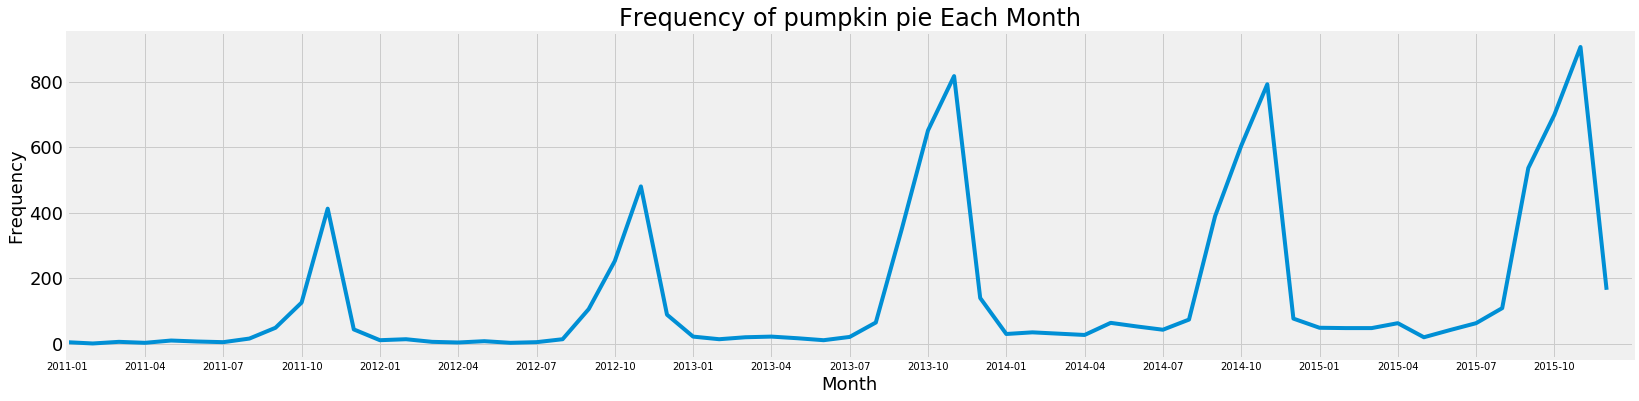

In [196]:
# Pumpkin Pie
get_food_trend('pumpkin','pie')

<font size="3">As is shown, the frequency of the phrase</font> **<font size="3">'pumpkin pie'</font>** <font size="3">in Facebook Posts soars around every year around</font> **<font size="3">Thanksgiving</font>**.


$\qquad$**<font size="4">2.6 Detection</font>**

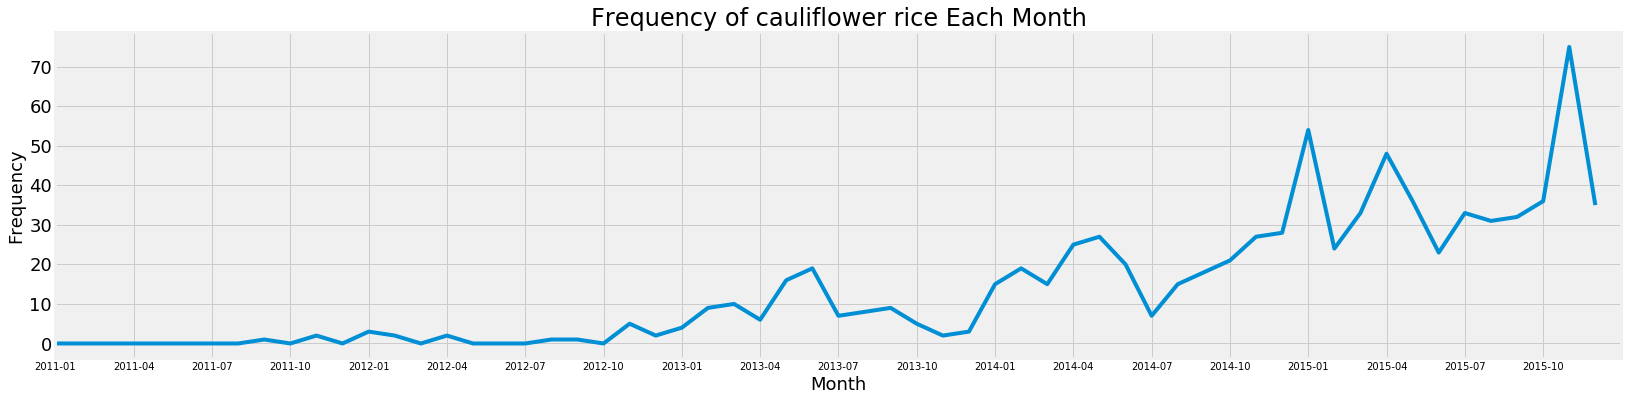

In [199]:
# Cauliflower Rice
get_food_trend('cauliflower','rice')

<font size="3">As is shown, the frequency of the phrase</font> **<font size="3">'cauliflower rice'</font>** <font size="3">in Facebook Posts has a smoothly increasing trend as early as</font> **<font size="3">2013</font>**<font size="3">, and the trend is even more obvious from</font> **<font size="3">2015</font>**.

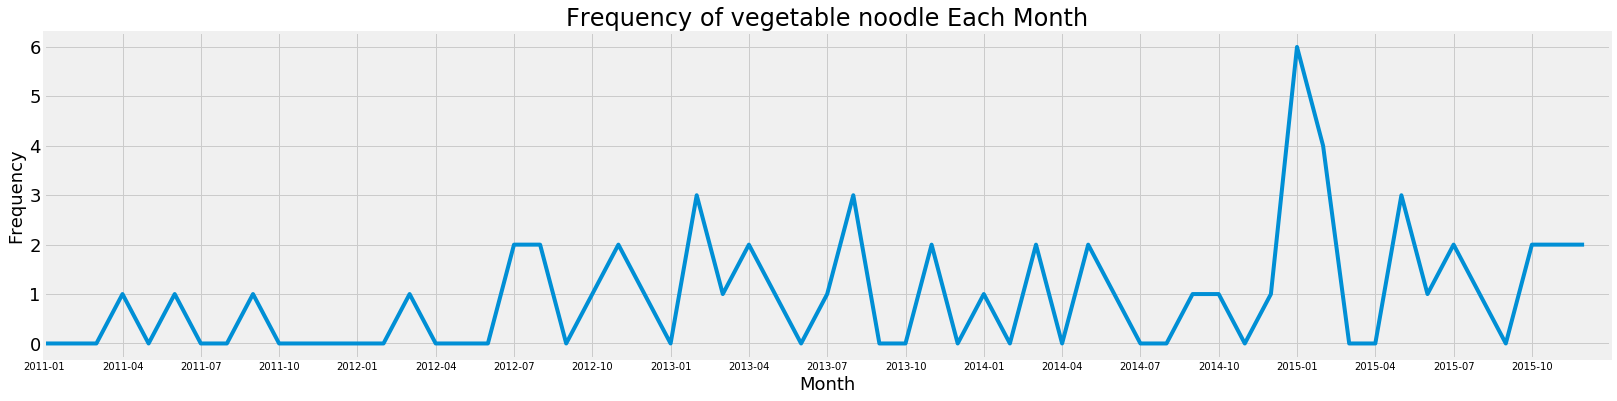

In [200]:
# Vegetable Noodle
get_food_trend('vegetable','noodle')

 <font size="3">As is shown, the frequency of the phrase</font> **<font size="3">'vegetable noodle'</font>** <font size="3">in Facebook increased in</font> **<font size="3">the middle of 2012</font>**<font size="3">, and was booming at</font> **<font size="3">January 2015</font>**<font size="3">, which has now been verified to be the effect of related mentions on</font> **<font size="3">Vogue</font>** <font size="3">and</font> **<font size="3">BBC</font>** <font size="3">that brewed vegetable spiralizing mania</font>.

**<font size="5">3 Summary</font>**

<font size="3">I collected data from Facebook posts, used co-occurrence matrix to show the frequence of a certain phrase containing two target words, organized the result in a time order and plotted the food trend from 2011 to 2015. 
<br>
<br> 'Pumpkin pie', 'cauliflower rice' and 'vegetable noodle' are three types of food I used for validation. All the trends are perfectly consistently with the reality and the detection model is correct.Users can also detect the emerging trend of other food they want, which can translate into great business opportunities.
</font> 

$\qquad$